In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/rice_dataset/train.csv')
data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
data.shape


(10407, 4)

In [ ]:
data['label'].unique().tolist()

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [ ]:
data['label'].nunique()

10

In [ ]:
data['age'].describe()

,age
count,10407.000000
mean,64.043624
std,8.958830
min,45.000000
25%,60.000000
50%,67.000000
75%,70.000000
max,82.000000


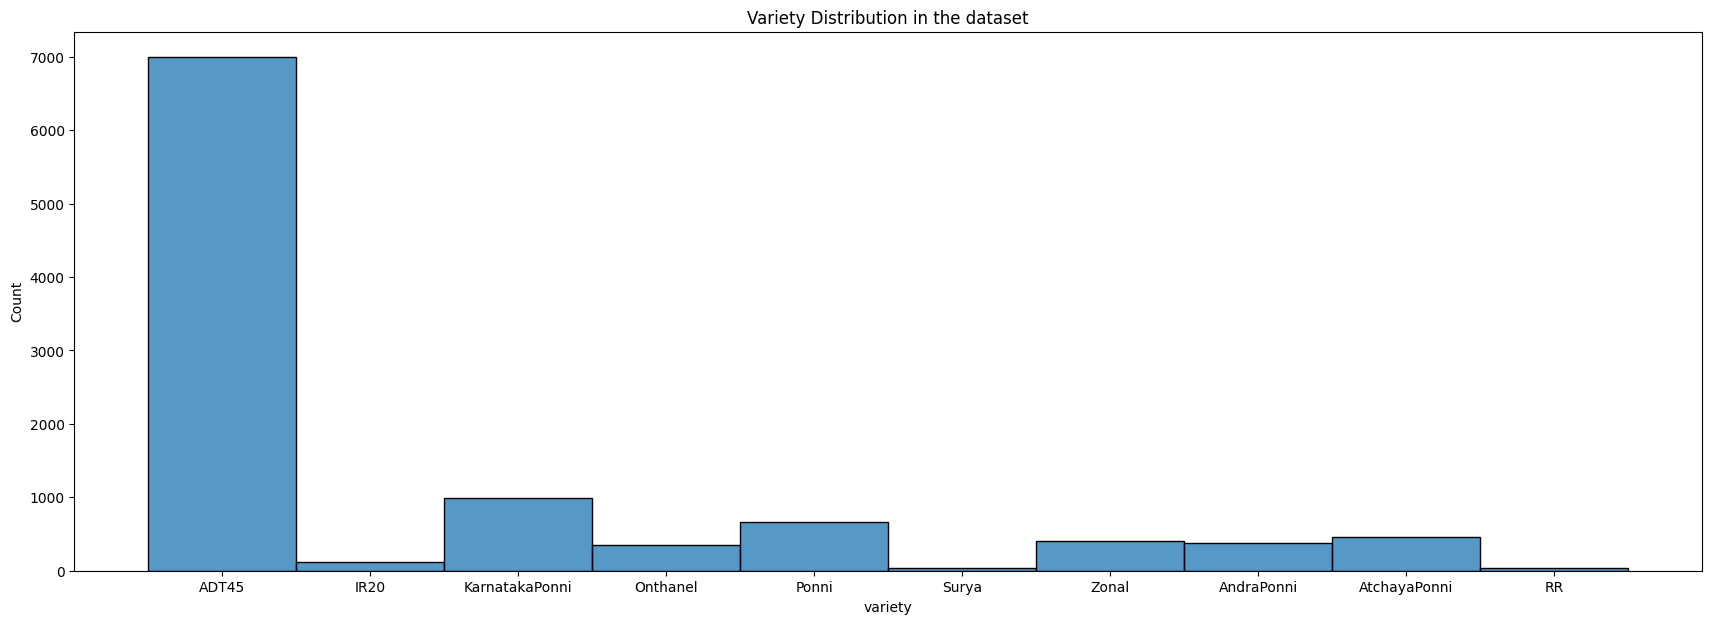

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='variety',ax=axes)
plt.title("Variety Distribution in the dataset")
plt.show()

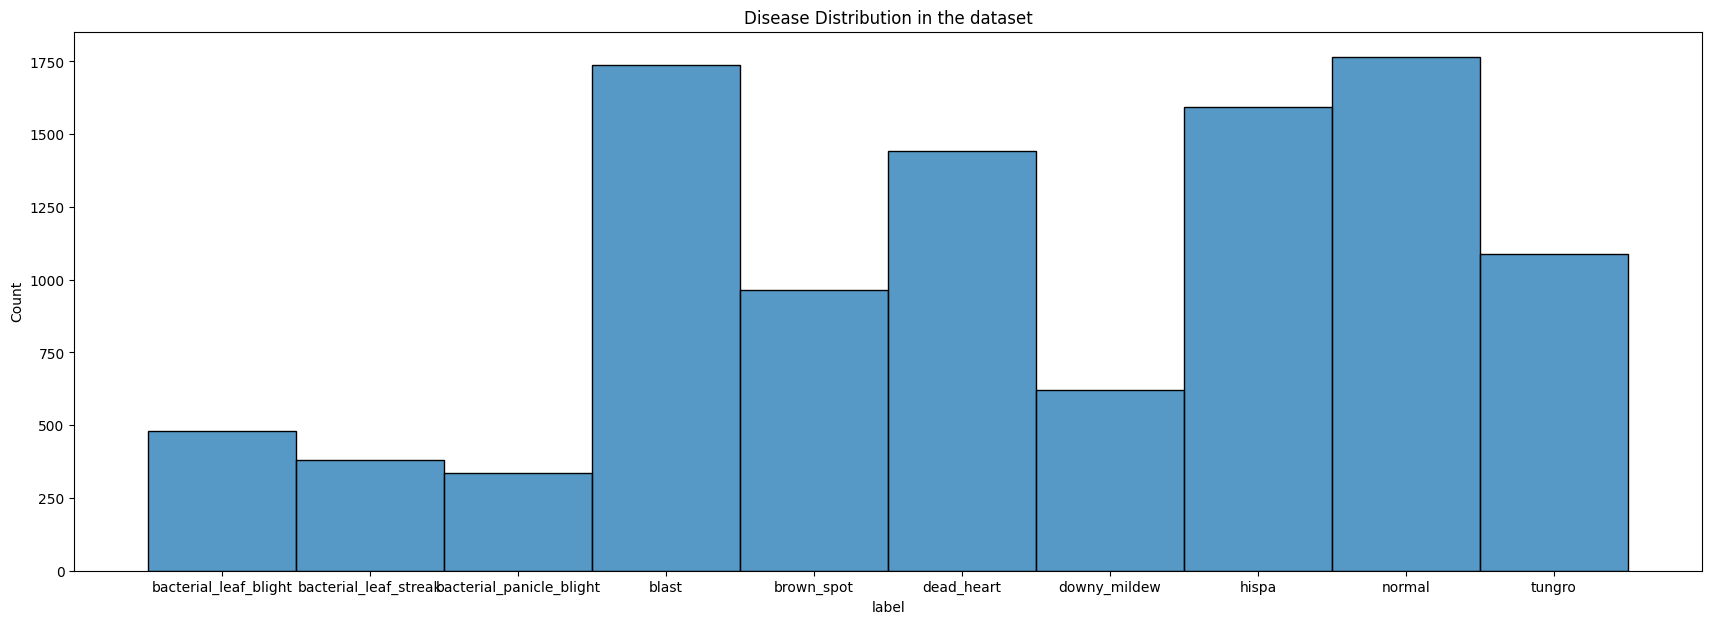

In [ ]:
fig,axes=plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='label',ax=axes)
plt.title("Disease Distribution in the dataset")
plt.show()

In [ ]:
normal=data[data['label']=='normal']
normal=normal[normal['variety']=='ADT45']
five_normals=normal.image_id[:5].values
five_normals

array(['100007.jpg', '100025.jpg', '100135.jpg', '100165.jpg',
       '100171.jpg'], dtype=object)

In [ ]:
normal=data[data['label']=='dead_heart']
normal=normal[normal['variety']=='ADT45']
five_deads=normal.image_id[:5].values
five_deads

array(['101165.jpg', '102750.jpg', '108367.jpg', '109900.jpg',
       '100222.jpg'], dtype=object)

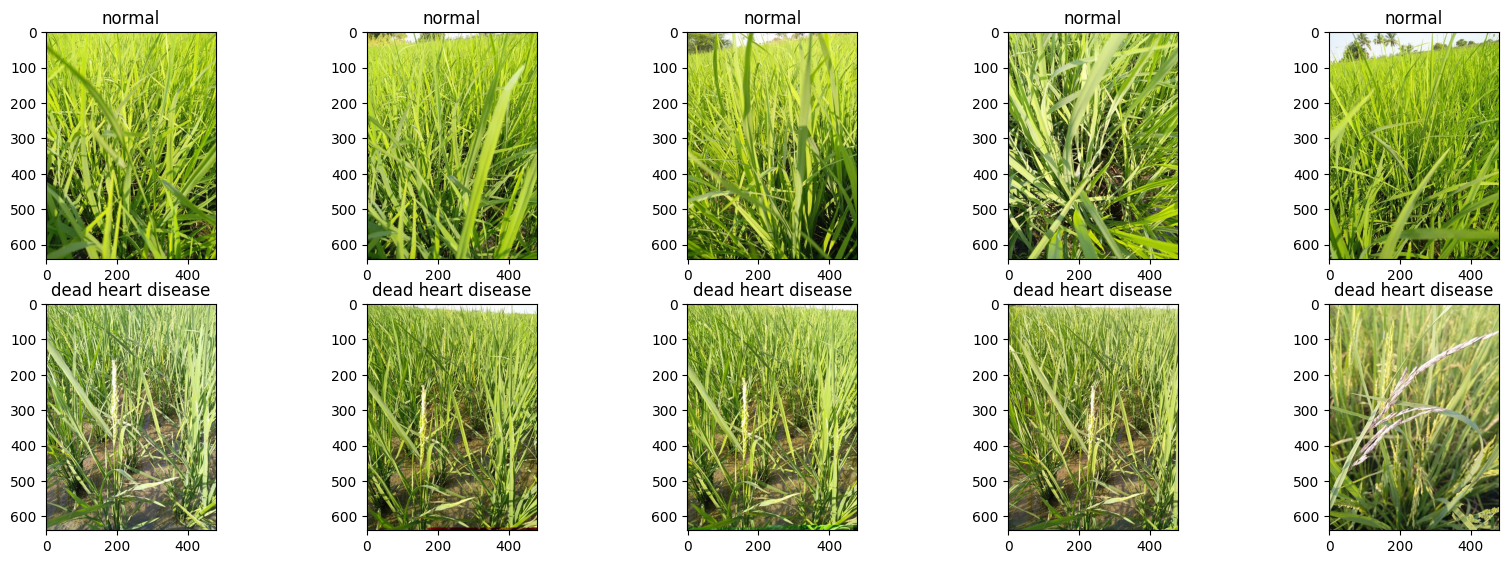

In [ ]:
plt.figure(figsize=(20,10))
columns=5
path='/content/drive/MyDrive/rice_dataset/train_images/'

for i, image_loc in enumerate(np.concatenate((five_normals, five_deads))):
    plt.subplot(10//columns + 1, columns, i + 1)

    if i < 5:
        image = plt.imread(path + "normal/" + image_loc)
        plt.title("normal")
    else:
        plt.title("dead heart disease")
        image = plt.imread(path + "dead_heart/" + image_loc)

    plt.imshow(image)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode target (label)
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

# Normalize age
scaler = MinMaxScaler()
data['age_scaled'] = scaler.fit_transform(data[['age']])

# One-Hot Encode variety
# Only apply get_dummies if 'variety' column exists
if 'variety' in data.columns:
    data = pd.get_dummies(data, columns=['variety'])

data.head()

,image_id,label,age,label_encoded,age_scaled,variety_ADT45,variety_AndraPonni,variety_AtchayaPonni,variety_IR20,variety_KarnatakaPonni,variety_Onthanel,variety_Ponni,variety_RR,variety_Surya,variety_Zonal
0,100330.jpg,bacterial_leaf_blight,45,0,0.0,True,False,False,False,False,False,False,False,False,False
1,100365.jpg,bacterial_leaf_blight,45,0,0.0,True,False,False,False,False,False,False,False,False,False
2,100382.jpg,bacterial_leaf_blight,45,0,0.0,True,False,False,False,False,False,False,False,False,False
3,100632.jpg,bacterial_leaf_blight,45,0,0.0,True,False,False,False,False,False,False,False,False,False
4,101918.jpg,bacterial_leaf_blight,45,0,0.0,True,False,False,False,False,False,False,False,False,False


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Lighter augmentation for speed + accuracy balance
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,       # Keep same validation split
    rotation_range=10,          # Reduced from 20 → faster, still good
    width_shift_range=0.05,     # Reduced from 0.1
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

In [ ]:
!cp -r /content/drive/MyDrive/rice_dataset/train_images /content/dataset


In [ ]:
!ls /content/dataset


bacterial_leaf_blight	  blast       downy_mildew  tungro
bacterial_leaf_streak	  brown_spot  hispa
bacterial_panicle_blight  dead_heart  normal


In [ ]:
# ✅ Copy dataset to local storage for faster access
data_dir = '/content/dataset'   # After copying from Drive

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=64,              # Increased batch size (fewer steps per epoch)
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 8330 images belonging to 10 classes.


In [ ]:
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=64,              # Match train batch size
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2077 images belonging to 10 classes.


In [ ]:
print("Number of training images:", train_generator.samples)
print("Number of validation images:", val_generator.samples)


Number of training images: 8330
Number of validation images: 2077


In [ ]:
class_name = list(train_generator.class_indices.keys())
print(class_name)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [ ]:
from os import access
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.layers import BatchNormalization

model=Sequential(
    [
        Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(224,224,3)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64,(3,3),activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
         Conv2D(64, (3,3), padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), padding='same',activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(10, activation='softmax')  # output layer
])

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,       # stop after 5 epochs of no improvement
    restore_best_weights=True
)

# Save best model
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_rice_cnn.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Reduce LR when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,       # reduce LR by 20%
    patience=3,
    min_lr=1e-6
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr,checkpoint],
    verbose=1
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.1863 - loss: 2.9108

131/131 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.1867 - loss: 2.9085 - val_accuracy: 0.1035 - val_loss: 2.5710 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.3276 - loss: 2.1826

131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.3278 - loss: 2.1817 - val_accuracy: 0.1531 - val_loss: 2.8700 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.4086 - loss: 1.8673

131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4087 - loss: 1.8669 - val_accuracy: 0.1940 - val_loss: 2.9127 - learning_rate: 1.0000e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.4614 - loss: 1.6728

131/131 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.4615 - loss: 1.6725 - val_accuracy: 0.3370 - val_loss: 2.0707 - learning_rate: 1.0000e-04
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.5075 - loss: 1.5061

131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.5076 - loss: 1.5059 - val_accuracy: 0.5566 - val_loss: 1.3839 - learning_rate: 1.0000e-04
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.5381 - loss: 1.4290

131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5382 - loss: 1.4286 - val_accuracy: 0.6172 - val_loss: 1.1943 - learning_rate: 1.0000e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5646 - loss: 1.3217 - val_accuracy: 0.6134 - val_loss: 1.1661 - learning_rate: 1.0000e-04
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.6021 - loss: 1.2164

131/131 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.6022 - loss: 1.2162 - val_accuracy: 0.6379 - val_loss: 1.1119 - learning_rate: 1.0000e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.6280 - loss: 1.1556

131/131 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.6281 - loss: 1.1553 - val_accuracy: 0.6808 - val_loss: 1.0136 - learning_rate: 1.0000e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.6423 - loss: 1.0611

131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6424 - loss: 1.0610 - val_accuracy: 0.6870 - val_loss: 0.9798 - learning_rate: 1.0000e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.6692 - loss: 1.0047

131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.6692 - loss: 1.0047 - val_accuracy: 0.7126 - val_loss: 0.9355 - learning_rate: 1.0000e-04
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6906 - loss: 0.9303 - val_accuracy: 0.6712 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7052 - loss: 0.9218

131/131 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7052 - loss: 0.9216 - val_accuracy: 0.7419 - val_loss: 0.8459 - learning_rate: 1.0000e-04
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.7284 - loss: 0.8322

131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7284 - loss: 0.8321 - val_accuracy: 0.7439 - val_loss: 0.8386 - learning_rate: 1.0000e-04
Epoch 15/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.7337 - loss: 0.8268

131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7337 - loss: 0.8268 - val_accuracy: 0.7617 - val_loss: 0.7834 - learning_rate: 1.0000e-04
Epoch 16/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.7477 - loss: 0.7858

131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7477 - loss: 0.7858 - val_accuracy: 0.7795 - val_loss: 0.7273 - learning_rate: 1.0000e-04
Epoch 17/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7575 - loss: 0.7484 - val_accuracy: 0.7752 - val_loss: 0.7203 - learning_rate: 1.0000e-04
Epoch 18/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.7660 - loss: 0.7278

131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7660 - loss: 0.7277 - val_accuracy: 0.7891 - val_loss: 0.6968 - learning_rate: 1.0000e-04
Epoch 19/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7868 - loss: 0.6634

131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7868 - loss: 0.6634 - val_accuracy: 0.7963 - val_loss: 0.6244 - learning_rate: 1.0000e-04
Epoch 20/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.7944 - loss: 0.6360

131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7944 - loss: 0.6360 - val_accuracy: 0.8021 - val_loss: 0.6282 - learning_rate: 1.0000e-04
Epoch 21/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7944 - loss: 0.6620 - val_accuracy: 0.7987 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 22/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8012 - loss: 0.6109 - val_accuracy: 0.7742 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 23/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.8181 - loss: 0.5665

131/131 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8181 - loss: 0.5665 - val_accuracy: 0.8286 - val_loss: 0.5492 - learning_rate: 2.0000e-05
Epoch 24/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.8271 - loss: 0.5499

131/131 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8271 - loss: 0.5499 - val_accuracy: 0.8334 - val_loss: 0.5219 - learning_rate: 2.0000e-05
Epoch 25/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 861ms/step - accuracy: 0.8295 - loss: 0.5339

131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8294 - loss: 0.5340 - val_accuracy: 0.8575 - val_loss: 0.5031 - learning_rate: 2.0000e-05
Epoch 26/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8352 - loss: 0.5180 - val_accuracy: 0.8402 - val_loss: 0.5229 - learning_rate: 2.0000e-05
Epoch 27/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8465 - loss: 0.4955 - val_accuracy: 0.8493 - val_loss: 0.5136 - learning_rate: 2.0000e-05
Epoch 28/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8404 - loss: 0.5069 - val_accuracy: 0.8445 - val_loss: 0.5067 - learning_rate: 2.0000e-05
Epoch 29/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8505 - loss: 0.4707 - val_accuracy: 0.8522 - val_loss: 0.5004 - learning_rate: 4.0000e-06
Epoch 30/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.8382 - loss: 0.4962

131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8382 - loss: 0.4963 - val_accuracy: 0.8623 - val_loss: 0.4804 - learning_rate: 4.0000e-06
Epoch 31/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8343 - loss: 0.5095 - val_accuracy: 0.8479 - val_loss: 0.4944 - learning_rate: 4.0000e-06
Epoch 32/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8433 - loss: 0.4828 - val_accuracy: 0.8517 - val_loss: 0.4970 - learning_rate: 4.0000e-06
Epoch 33/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8421 - loss: 0.5037 - val_accuracy: 0.8580 - val_loss: 0.4828 - learning_rate: 4.0000e-06
Epoch 34/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8375 - loss: 0.4974 - val_accuracy: 0.8522 - val_loss: 0.4988 - learning_rate: 1.0000e-06
Epoch 35/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.8531 - loss: 0.4721 - val_accuracy: 0.8498 - val_loss: 0.4963 - learning_rate: 1.0000e-06
Epoch 36/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/best_rice_cnn.h5')


In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model

# ✅ Load the trained model
model_path = '/content/drive/MyDrive/best_rice_cnn.h5'
model = load_model(model_path)
print("✅ Model Loaded Successfully")

# ✅ Path to your test images (flat folder)
test_dir = '/content/drive/MyDrive/rice_dataset/test_images'

# ✅ Define target size (must match training)
img_size = (224, 224)

# ✅ Class labels from training (MUST match your training classes)
class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
                'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

# ✅ Collect all image paths
image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_names = [os.path.basename(p) for p in image_paths]

print(f"✅ Loaded {len(image_paths)} test images")

# ✅ Preprocess and predict
predictions = []
predicted_classes = []

for img_path in image_paths:
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # rescale like training
    img_array = np.expand_dims(img_array, axis=0)  # add batch dim

    pred = model.predict(img_array, verbose=0)
    pred_idx = np.argmax(pred)

    predictions.append(pred)
    predicted_classes.append(pred_idx)

# ✅ Prepare DataFrame for results
results = []
for i, img_name in enumerate(image_names):
    pred_idx = predicted_classes[i]
    confidence = predictions[i][0][pred_idx]
    results.append({
        "Image": img_name,
        "Predicted_Class": class_labels[pred_idx],
        "Confidence": round(float(confidence), 4)
    })

df_results = pd.DataFrame(results)

# ✅ Display first few predictions
print(df_results.head(10))

# ✅ Save results to CSV
output_csv = '/content/drive/MyDrive/rice_test_predictions.csv'
df_results.to_csv(output_csv, index=False)
print(f"✅ Predictions saved to: {output_csv}")


✅ Model Loaded Successfully
✅ Loaded 3469 test images
        Image Predicted_Class  Confidence
0  202466.jpg           blast      0.9898
1  202352.jpg           hispa      0.9068
2  202461.jpg          normal      0.9992
3  202535.jpg          normal      0.5428
4  202437.jpg           blast      0.4875
5  202506.jpg           blast      0.4965
6  202357.jpg          normal      0.9833
7  202413.jpg      dead_heart      0.6010
8  202369.jpg          tungro      0.8019
9  202353.jpg          normal      0.7100
✅ Predictions saved to: /content/drive/MyDrive/rice_test_predictions.csv


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np



class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
                'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


# ✅ Path to your image (upload or give full path)
img_path = '/content/drive/MyDrive/test_image.png'
# ✅ Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # same size as training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
img_array = img_array / 255.0  # rescale like training

# ✅ Predict
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"✅ Predicted Disease: {predicted_class}")
print(f"✅ Confidence: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
✅ Predicted Disease: bacterial_panicle_blight
✅ Confidence: 91.76%


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np



class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
                'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


# ✅ Path to your image (upload or give full path)
img_path ='/content/drive/MyDrive/test_image1.jpg'
# ✅ Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # same size as training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
img_array = img_array / 255.0  # rescale like training

# ✅ Predict
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"✅ Predicted Disease: {predicted_class}")
print(f"✅ Confidence: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
✅ Predicted Disease: normal
✅ Confidence: 99.92%


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np



class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
                'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']



# ✅ Path to your image (upload or give full path)
img_path ='/content/drive/MyDrive/test.jpg'
# ✅ Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # same size as training
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
img_array = img_array / 255.0  # rescale like training

# ✅ Predict
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]
confidence = np.max(prediction)

print(f"✅ Predicted Disease: {predicted_class}")
print(f"✅ Confidence: {confidence * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
✅ Predicted Disease: blast
✅ Confidence: 35.59%


In [ ]:
print(train_generator.class_indices)



{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ✅ 1. Define paths
test_dir = '/content/drive/MyDrive/rice_dataset/test_images'

# ✅ 3. Load model (assuming already loaded as 'model')

# ✅ 4. Create test generator (no subfolders, so we'll load manually)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=data,
    directory=test_dir,
    x_col='image_id',  # column name of image filenames in CSV
    y_col='label',     # column name of actual class labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ✅ 5. Predict
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# ✅ 6. Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy on test set: {accuracy*100:.2f}%")

# ✅ 7. Detailed report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# ✅ 8. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


Found 0 validated image filenames belonging to 0 classes.


ValueError: The PyDataset has length 0